In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots as sgr
from analysis_tools import plot_trend
import matplotlib.ticker as ticker

In [2]:
data = pd.read_csv("results-22-Mar-2018.csv", index_col=0)
data['host'] = 'rapi'
data['watts'] = .5*5
more_data = pd.read_csv("outputfileMac6.csv", index_col=0)
more_data['host'] = 'laptop'
more_data['watts'] = 27.52
data = pd.concat([data, more_data])
data = data.query('file_count <= 18')
data['pitime_per_file'] = data['time']*data['pi_count']/data['file_count']

#print(data.query('host == "rapi" & pi_count == 5 & file_count == 5'))
data = data.query('pi_count != 6')

data['Ws_per_pi'] = data['watts']*data['time']
data['Ws'] = data['Ws_per_pi']*data['pi_count']
#data.groupby(['host','pi_count','file_count'])['Ws'].describe()

In [3]:
from pathlib import Path
import sox.file_info as file_info
p = Path('pieces')
sizes = [{'number':i, 
          'filename':x, 
          'size':x.stat().st_size, 
          'length': file_info.duration(str(x))} for i,x in enumerate(sorted(p.glob('*')))]
sizes = pd.DataFrame(sizes)
sizes['total_size'] = sizes['size'].cumsum()
word_counts = pd.read_csv('text_lengths.csv',
                          header=None,
                          names=['number', 'word_count', 'text'],
                          usecols=['word_count', 'text'])
sizes['number'] += 1
sizes = pd.concat([sizes, word_counts], axis=1)
sizes.index = sizes.index + 1
sizes['total_words'] = sizes['word_count'].cumsum()
sizes['total_length'] = sizes['length'].cumsum()

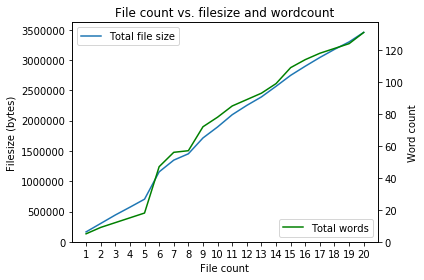

In [4]:
sizes = sizes[:20]
fig, ax = plt.subplots()
ax2 = ax.twinx()
line, = ax.plot(sizes['number'], sizes['total_size'])
line.set_label('Total file size')
line, = ax2.plot(sizes['number'], sizes['total_words'], 'g')
line.set_label('Total words')
ax2.set_ylabel("Word count")
ax.set_ylabel("Filesize (bytes)")
ax.set_xlabel("File count")
ax.legend(loc='upper left')
ax2.legend(loc='lower right')
ax.set_title("File count vs. filesize and wordcount")
ax.set_ybound(lower=0)
ax2.set_ybound(lower=0)
ax.set_xticks(sizes['number'])
fig.tight_layout()
fig.savefig("file_count_vs_filesize_with_wordcount.png")

In [5]:
sizes = sizes.loc[4:18]

Intercept           3146.097944
np.log(pi_count)   -1409.409747
dtype: float64
8.135642855099809


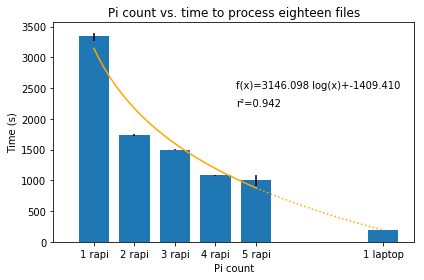

In [24]:
dat = data.query('file_count == 18').copy()
mod = smf.ols(formula='time ~ np.log(pi_count)', data=dat.query('host == "rapi"'))
res = mod.fit()

print(res.params)

laptop_time = dat.query('host == "laptop"')['time'].mean()
def pi_count_from_time(time):
    return np.exp((time-res.params['Intercept'])/res.params['np.log(pi_count)'])
estimated_pi_time = pi_count_from_time(laptop_time)
print(estimated_pi_time)

fig, ax = plt.subplots()
grp = dat.groupby(['pi_count', 'host'])
mean = grp.mean()
names = [' '.join(str(s) for s in x) for x in mean.index.values]
error = [mean['time']-grp['time'].min(),grp['time'].max()-mean['time']]
numbers = [estimated_pi_time,1,2,3,4,5]
ax.bar(numbers, mean['time'], 0.75, tick_label=names, yerr=error)
ax.set_ylim(bottom=0)
ax.set_xlabel('Pi count')
ax.set_ylabel('Time (s)')
ax.set_title("Pi count vs. time to process eighteen files")
xs = np.linspace(1,5)
ys = res.predict({"pi_count":xs, "host":"rapi"})
line, = ax.plot(xs, ys, 'orange')
xs = np.linspace(5, estimated_pi_time)
ys = res.predict({"pi_count":xs, "host":"rapi"})
ax.plot(xs, ys, ':', color='orange')
ax.text(4.5, 2500, "f(x)={:.3f} log(x)+{:.3f}".format(*res.params))
ax.text(4.5, 2200, "r²={:.3f}".format(res.rsquared))
ax.set_xlim(left=0)
#ax.annotate(s="{:.3f}".format(estimated_pi_time), xy=(estimated_pi_time, laptop_time), xytext=(estimated_pi_time, laptop_time+200), horizontalalignment='center')
fig.tight_layout()
fig.savefig("pi_count_vs_time.png")

In [7]:
laptop_time = data.query('host == "laptop" & file_count == 18')['time'].mean()
def pi_count_from_time(time):
    return np.exp((time-res.params['Intercept'])/res.params['np.log(pi_count)'])
print(pi_count_from_time(laptop_time))
print(laptop_time)
print(data.query('host == "laptop"'))

8.135642855099809
191.61605220370822
    file_count  pi_count        time     timestamp    host  watts  \
0            5         1   42.665680  1.521741e+09  laptop  27.52   
1            5         1   42.892954  1.521741e+09  laptop  27.52   
2            5         1   43.503964  1.521741e+09  laptop  27.52   
3            5         1   43.151668  1.521741e+09  laptop  27.52   
4            5         1   43.061880  1.521741e+09  laptop  27.52   
5            5         1   42.987186  1.521741e+09  laptop  27.52   
6            6         1   65.870512  1.521749e+09  laptop  27.52   
7            6         1   63.586253  1.521749e+09  laptop  27.52   
8            6         1   64.562884  1.521749e+09  laptop  27.52   
9           10         1  125.127617  1.521839e+09  laptop  27.52   
10          10         1  120.454715  1.521839e+09  laptop  27.52   
11          10         1  120.795403  1.521839e+09  laptop  27.52   
12          10         1  125.763201  1.521839e+09  laptop  27.52 

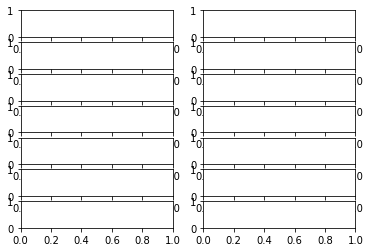

In [8]:
groups = data.groupby('file_count')
fig, ax = plt.subplots(7,2)
#ax.apply(lambda x: x.set_frame_on(False))
for i, (count, grp) in enumerate(groups):
    #ax[i//2, i%2].set_frame_on(False)
    pass
#sns.stripplot(x='pi_count', y='pitime_per_file', hue='host', data=data, ax=ax)
#ax.set_ylim(bottom=0)
#fig.savefig("pitime_per_file_vs_count.png")

In [9]:
onejump = data['pi_count'].apply(lambda x: x in [1,2,5])

In [10]:
data.loc[onejump]['pitime_per_file'].mean()

224.51980963721599

In [11]:
curve_up = data['pi_count'].apply(lambda x: x in [2,3,4])
count_mod = smf.ols(formula='pitime_per_file ~ pi_count', data=data.loc[curve_up])
count_res = count_mod.fit()
count_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        pitime_per_file   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     17.63
Date:                Fri, 23 Mar 2018   Prob (F-statistic):           4.17e-05
Time:                        19:31:34   Log-Likelihood:                -978.36
No. Observations:                 187   AIC:                             1961.
Df Residuals:                     185   BIC:                             1967.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    211.7436     12.977     16.316      0.000     186.141     237.346
pi_count      17.5231      4.174      4.199      0.000       9.289      25.757
==============================================================================
Omnibus:                        0.300   Durbin-Watson:                   0.637
Prob(Omnibus):                  0.861   Jarque-Bera (JB):                0.117
Skew:                           0.045   Prob(JB):                        0.943
Kurtosis:                       3.082   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

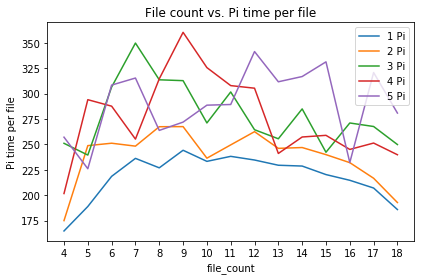

In [12]:
fig, ax = plt.subplots()
pidata = data.query('host == "rapi"')
for count, grp in pidata.groupby('pi_count'):
    grp = grp.groupby('file_count').mean()
    line, = ax.plot(grp.index, grp['pitime_per_file'], '-')
    line.set_label(str(count) + " Pi")
ax.set_xlabel("file_count")
ax.set_ylabel("Pi time per file")
ax.set_title("File count vs. Pi time per file")
ax.set_xticks(pidata['file_count'].unique())
ax.legend()
#ax.set_ylim(bottom=0)
fig.tight_layout()
fig.savefig('file_count_vs_pitime_per_file.png')

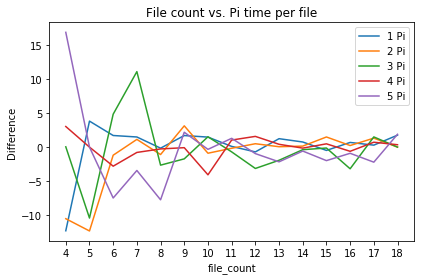

In [13]:
fig, ax = plt.subplots()
pidata = data.loc[data['host'] == 'rapi']
for count, grp in pidata.groupby('pi_count'):
    grp = grp.groupby('file_count')
    median = grp.median()
    mean = grp.mean()
    diff = median-mean
    line, = ax.plot(diff.index, diff['pitime_per_file'], '-')
    line.set_label(str(count) + " Pi")
ax.set_xlabel("file_count")
ax.set_ylabel("Difference")
ax.set_title("File count vs. Pi time per file")
ax.set_xticks(pidata['file_count'].unique())
ax.legend()
fig.tight_layout()
#fig.savefig('file_count_vs_pitime_per_file.png')

/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


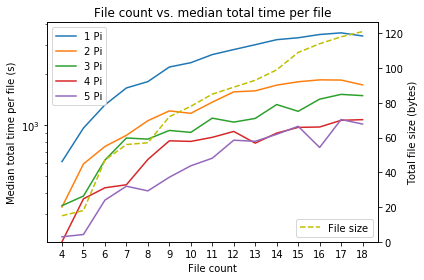

In [29]:
fig, ax = plt.subplots()
pidata = data.query('host == "rapi"')
for count, grp in pidata.groupby('pi_count'):
    grp = grp.groupby('file_count').median()
    line, = ax.plot(grp.index, grp['time'], '-')
    line.set_label(str(count) + " Pi")
ax2 = ax.twinx()
ax2.set_ylabel("Total file size (bytes)")
line, = ax2.plot(sizes['number'], sizes['total_words'], '--y')
line.set_label("File size")
ax2.legend(loc='lower right')
ax.set_xlabel("File count")
ax.set_ylabel("Median total time per file (s)")
ax.set_yscale('log')
#ax2.set_yscale('log')
ax.set_title("File count vs. median total time per file")
ax.set_xticks(pidata['file_count'].unique())
ax.legend(loc='upper left')
ax.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
fig.tight_layout()
fig.savefig('file_count_vs_median_total_time_per_file_with_file_size.png')
# Add more axis numbers on y-axes

In [35]:
laptop_means = data.query('host=="laptop"').groupby('file_count').mean()
for file_count in laptop_means.index.values:
    laptop_means.loc[file_count, 'words_per_second'] = \
    sizes.loc[file_count, 'total_words']/laptop_means.loc[file_count, 'time']
laptop_means.mean()

pi_count            1.000000e+00
time                1.041974e+02
timestamp           1.521793e+09
watts               2.752000e+01
pitime_per_file     1.044466e+01
Ws_per_pi           2.867513e+03
Ws                  2.867513e+03
words_per_second    6.101136e-01
dtype: float64

Human performance: 155 words/min

In [36]:
155/60

2.5833333333333335

In [15]:
means_for_file_count = data.query('host=="rapi"').groupby(['pi_count', 'file_count']).mean()
for pi_count, file_count in means_for_file_count.index.values:
    means_for_file_count.loc[(pi_count, file_count), 'words_per_second'] = \
    sizes.loc[file_count, 'total_words']/means_for_file_count.loc[(pi_count, file_count), 'time']

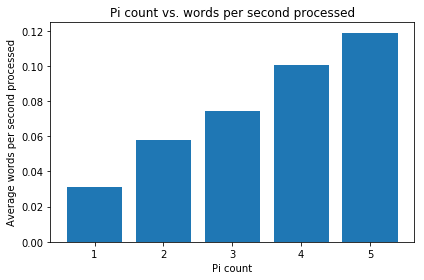

In [16]:
ficount = means_for_file_count.groupby('pi_count').mean()
fig, ax = plt.subplots()
labels = [str(x) + ' Pis' for x in ficount.index]
ax.bar(labels, ficount['words_per_second'])
ax.set_xlabel("Pi count")
ax.set_ylabel("Average words per second processed")
ax.set_title("Pi count vs. words per second processed")
fig.tight_layout()
fig.savefig("pi_count_vs_avg_words_per_second")

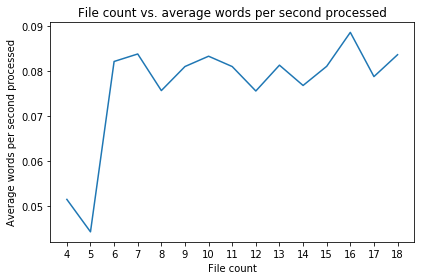

In [17]:
ficount = means_for_file_count.groupby('file_count').mean()
fig, ax = plt.subplots()
ax.plot(ficount.index, ficount['words_per_second'])
ax.set_xticks(ficount.index)
ax.set_xlabel("File count")
ax.set_ylabel("Average words per second processed")
ax.set_title("File count vs. average words per second processed")
fig.tight_layout()
fig.savefig("file_count_vs_avg_words_per_second")

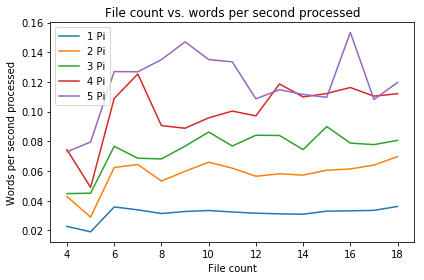

In [18]:
fig, ax = plt.subplots()
for pi_count, grp in means_for_file_count.groupby('pi_count'):
    line, = ax.plot(grp.index.get_level_values('file_count'), grp['words_per_second'])
    line.set_label(str(pi_count) + ' Pi')
ax.legend()
ax.set_xlabel("File count")
ax.set_ylabel("Words per second processed")
ax.set_title("File count vs. words per second processed")
fig.tight_layout()
fig.savefig("file_count_vs_words_per_second_processed")

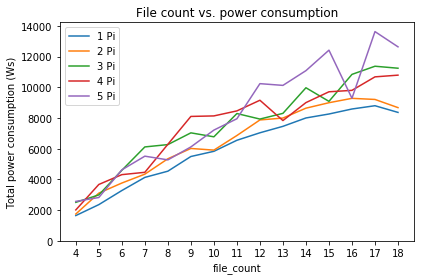

In [19]:
fig, ax = plt.subplots()
dat = data.query('host == "rapi"')
for count, grp in dat.groupby('pi_count'):
    grp = grp.groupby('file_count').mean()
    line, = ax.plot(grp.index, grp['Ws'], '-')
    line.set_label(str(count) + " Pi")
ax.set_xlabel("file_count")
ax.set_ylabel("Total power consumption (Ws)")
ax.set_title("File count vs. power consumption")
ax.set_xticks(dat['file_count'].unique())
ax.legend()
ax.set_ylim(bottom=0)
fig.tight_layout()
fig.savefig('pi_count_vs_Ws.png')